In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pdb
from tqdm import tqdm
from collections import OrderedDict
import copy

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, './src')
from data import Dataset
from models import HMC_vanilla

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['dataset_name'] = 'boston_housing'
if args['dataset_name'].find('mnist') > -1:
    args['num_epoches'] = 201
    args['print_info'] = 50
    args['n_IS'] = 10000
    
    args['train_batch_size'] = 100
    args['val_dataset'] = 10000
    args['val_batch_size'] = 100
    args['test_batch_size'] = 100
else:
    args['n_IS'] = 1000
    args['num_epoches'] = 10001
    args['print_info'] = 1000
    args['train_batch_size'] = 100
    args['val_dataset'] = 100
    args['val_batch_size'] = 20
    args['test_batch_size'] = 10

In [5]:
dataset = Dataset(args)
args.in_features = dataset.in_features[0]
dataset.in_features[0]

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 406


13

In [6]:
X_train = torch.tensor(dataset.x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(dataset.y_train, device=device, dtype=torch.float32)

X_val = torch.tensor(dataset.x_val, device=device, dtype=torch.float32)
y_val = torch.tensor(dataset.y_val, device=device, dtype=torch.float32)

In [7]:
def load_parameters(model, param_vector, params_shapes):
    left_boader = 0
    tensors = []
    for shape in params_shapes:
        cur_len = np.prod(shape)
        tensors.append(param_vector[left_boader: left_boader+cur_len].view(*shape))
        left_boader += cur_len
    d = OrderedDict()
    model_clone = copy.deepcopy(model)
    for i, name in enumerate(model_clone.named_parameters()):
        d[name[0]] = tensors[i]
    model_clone.load_state_dict(d)
    model_clone.to(model.device)
    return model_clone

$p(w|x) = \frac{p(w, x)}{\int p(x, w)dw} \sim p(x|w)p(w)$

In [8]:
class Simple_model(nn.Module):
    def __init__(self, args):
        super(Simple_model, self).__init__()
        in_features = args.in_features
        self.device = args.device
        self.l1 = nn.Linear(in_features, 3*in_features)
        self.l2 = nn.Linear(3*in_features, 1)
        self.activation = nn.Softplus()
        self.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=self.device),
                                                     scale=torch.tensor(1., dtype=torch.float32, device=self.device))
        
    def forward(self, x):
        h = self.activation(self.l1(x))
        h = self.l2(h)
        return h
    
    def log_prob(self, x, z):
        '''
        x - data vector
        z - vector of all parameters
        '''
#         pdb.set_trace()
        log_prior = self.std_normal.log_prob(z[0]).sum()
        loaded_model = load_parameters(self, z[0], params_shapes)
        y_pred = loaded_model(x)
        log_likelihood = torch.distributions.Normal(loc=y_train,
                                                     scale=torch.tensor(1., dtype=torch.float32, device=self.device)).log_prob(y_pred).sum()
#         print('log_likelihood', log_likelihood)
        logdensity = log_likelihood + log_prior
        return logdensity[None]

In [9]:
model = Simple_model(args)

In [10]:
params_shapes = [p.shape for p in list(model.parameters())]
print(params_shapes)
overall_params = sum([np.prod(el) for el in params_shapes])
print(f'Overall number of parameters is {overall_params}')

[torch.Size([39, 13]), torch.Size([39]), torch.Size([1, 39]), torch.Size([1])]
Overall number of parameters is 586


In [11]:
initial_parameters = torch.randn((overall_params, 1), dtype=torch.float32, device=device)

In [16]:
L = 100000 # num of hmc transitions
args.N = 3
args.alpha = 0.5
args.gamma = 0.01
args.use_partialref = False
args.use_barker = False


hmc_transition = HMC_vanilla(args)

In [17]:
q_new = initial_parameters
a_list = []

model_new = copy.deepcopy(load_parameters(model, q_new, params_shapes))

for l in tqdm(range(L)):
    q_new, _, a = hmc_transition.make_transition(q_old=q_new[None], p_old=None, target_distr=model_new, x=X_train)
    a_list.append(a.cpu().numpy())
    model_new = copy.deepcopy(load_parameters(model_new, q_new[0], params_shapes))
    q_new = q_new[0]
    if l % 1000 == 0:
        gamma = args.gamma
    gamma *= 0.99
    hmc_transition.gamma = torch.tensor(np.log(gamma), device=device)
    if l % 500 == 0:
        print(f'Mean acceptance rate {np.mean(a_list)}')
        a_list = []
        y_pred = model_new(X_train)
        print(f"At L={l} MSE on train is {((y_pred.squeeze() - y_train.squeeze())**2).mean()}")
        y_pred = model_new(X_val)
        print(f"At L={l} MSE on validation is {((y_pred.squeeze() - y_val.squeeze())**2).mean()}")

  0%|          | 12/5000 [00:00<00:44, 111.89it/s]

Mean acceptance rate 0.6660000085830688
At L=0 MSE on train is 33.913795471191406
At L=0 MSE on validation is 48.31769561767578


 10%|█         | 516/5000 [00:04<00:38, 115.45it/s]

Mean acceptance rate 0.0
At L=500 MSE on train is 33.913795471191406
At L=500 MSE on validation is 48.31769561767578


 20%|██        | 1020/5000 [00:08<00:34, 115.35it/s]

Mean acceptance rate 0.6359999775886536
At L=1000 MSE on train is 33.90091323852539
At L=1000 MSE on validation is 48.709632873535156


 30%|███       | 1524/5000 [00:13<00:30, 115.64it/s]

Mean acceptance rate 0.00800000037997961
At L=1500 MSE on train is 33.89754867553711
At L=1500 MSE on validation is 48.472900390625


 40%|████      | 2016/5000 [00:17<00:26, 114.23it/s]

Mean acceptance rate 0.6140000224113464
At L=2000 MSE on train is 33.922607421875
At L=2000 MSE on validation is 48.83075714111328


 50%|█████     | 2520/5000 [00:21<00:21, 115.06it/s]

Mean acceptance rate 0.014000000432133675
At L=2500 MSE on train is 33.899330139160156
At L=2500 MSE on validation is 48.429832458496094


 60%|██████    | 3024/5000 [00:26<00:16, 117.13it/s]

Mean acceptance rate 0.628000020980835
At L=3000 MSE on train is 33.88362503051758
At L=3000 MSE on validation is 49.12314987182617


 70%|███████   | 3516/5000 [00:30<00:12, 114.65it/s]

Mean acceptance rate 0.0020000000949949026
At L=3500 MSE on train is 33.88394546508789
At L=3500 MSE on validation is 48.96367645263672


 80%|████████  | 4020/5000 [00:34<00:08, 115.58it/s]

Mean acceptance rate 0.6340000033378601
At L=4000 MSE on train is 33.87116622924805
At L=4000 MSE on validation is 48.722381591796875


 90%|█████████ | 4524/5000 [00:39<00:04, 115.50it/s]

Mean acceptance rate 0.00800000037997961
At L=4500 MSE on train is 33.86616516113281
At L=4500 MSE on validation is 48.845703125


100%|██████████| 5000/5000 [00:43<00:00, 115.54it/s]


5it [00:00, 327.35it/s]


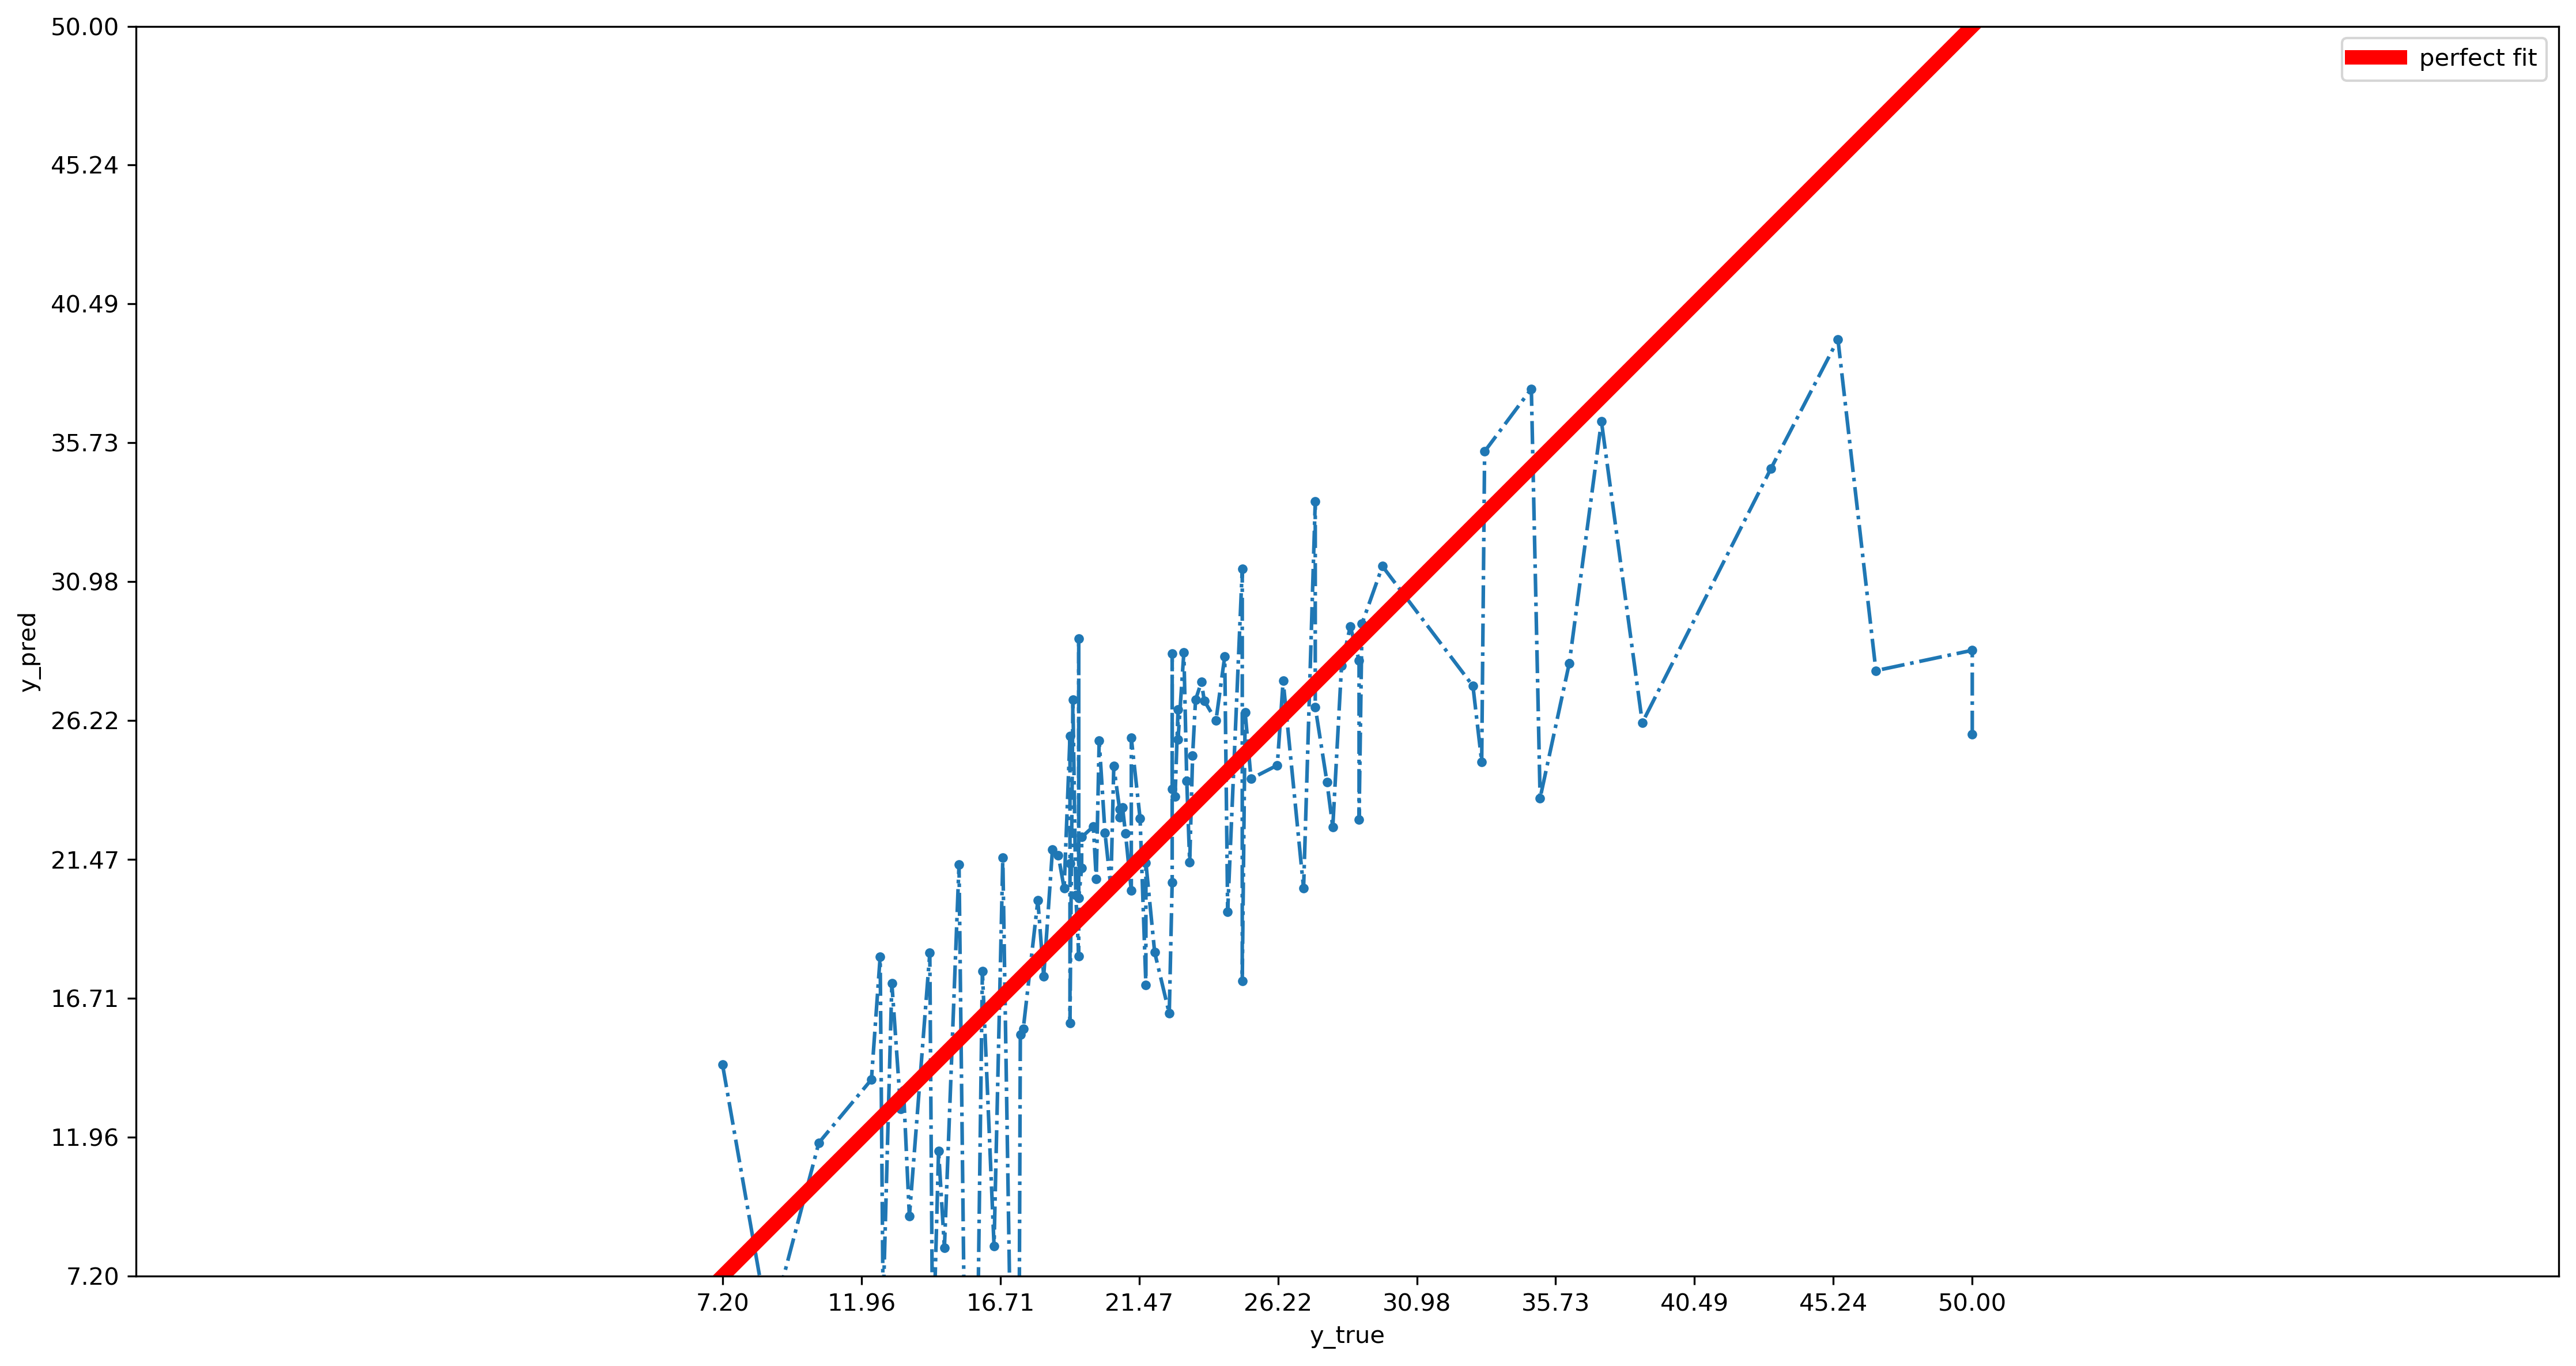

In [37]:
with torch.no_grad():
    predictions = torch.tensor([], device=device)
    true_ans = torch.tensor([], device=device)
    for val_batch, val_label in tqdm(dataset.next_val_batch()):
        preds = model_new(val_batch)
        predictions = torch.cat([predictions, preds], dim=0)
        true_ans = torch.cat([true_ans, val_label], dim=0)
    true_ans = true_ans.squeeze()
    predictions = predictions.squeeze()
    idx = torch.argsort(true_ans)
    true_ans = true_ans[idx].cpu().numpy()
    pred_ans = predictions[idx].cpu().numpy()
    
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(true_ans, pred_ans, '-..')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.axis('equal')
plt.xlim(true_ans.min(), true_ans.max())
plt.ylim(true_ans.min(), true_ans.max())
plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
plt.legend()
plt.tight_layout()
plt.show();

### Plot with uncertainty

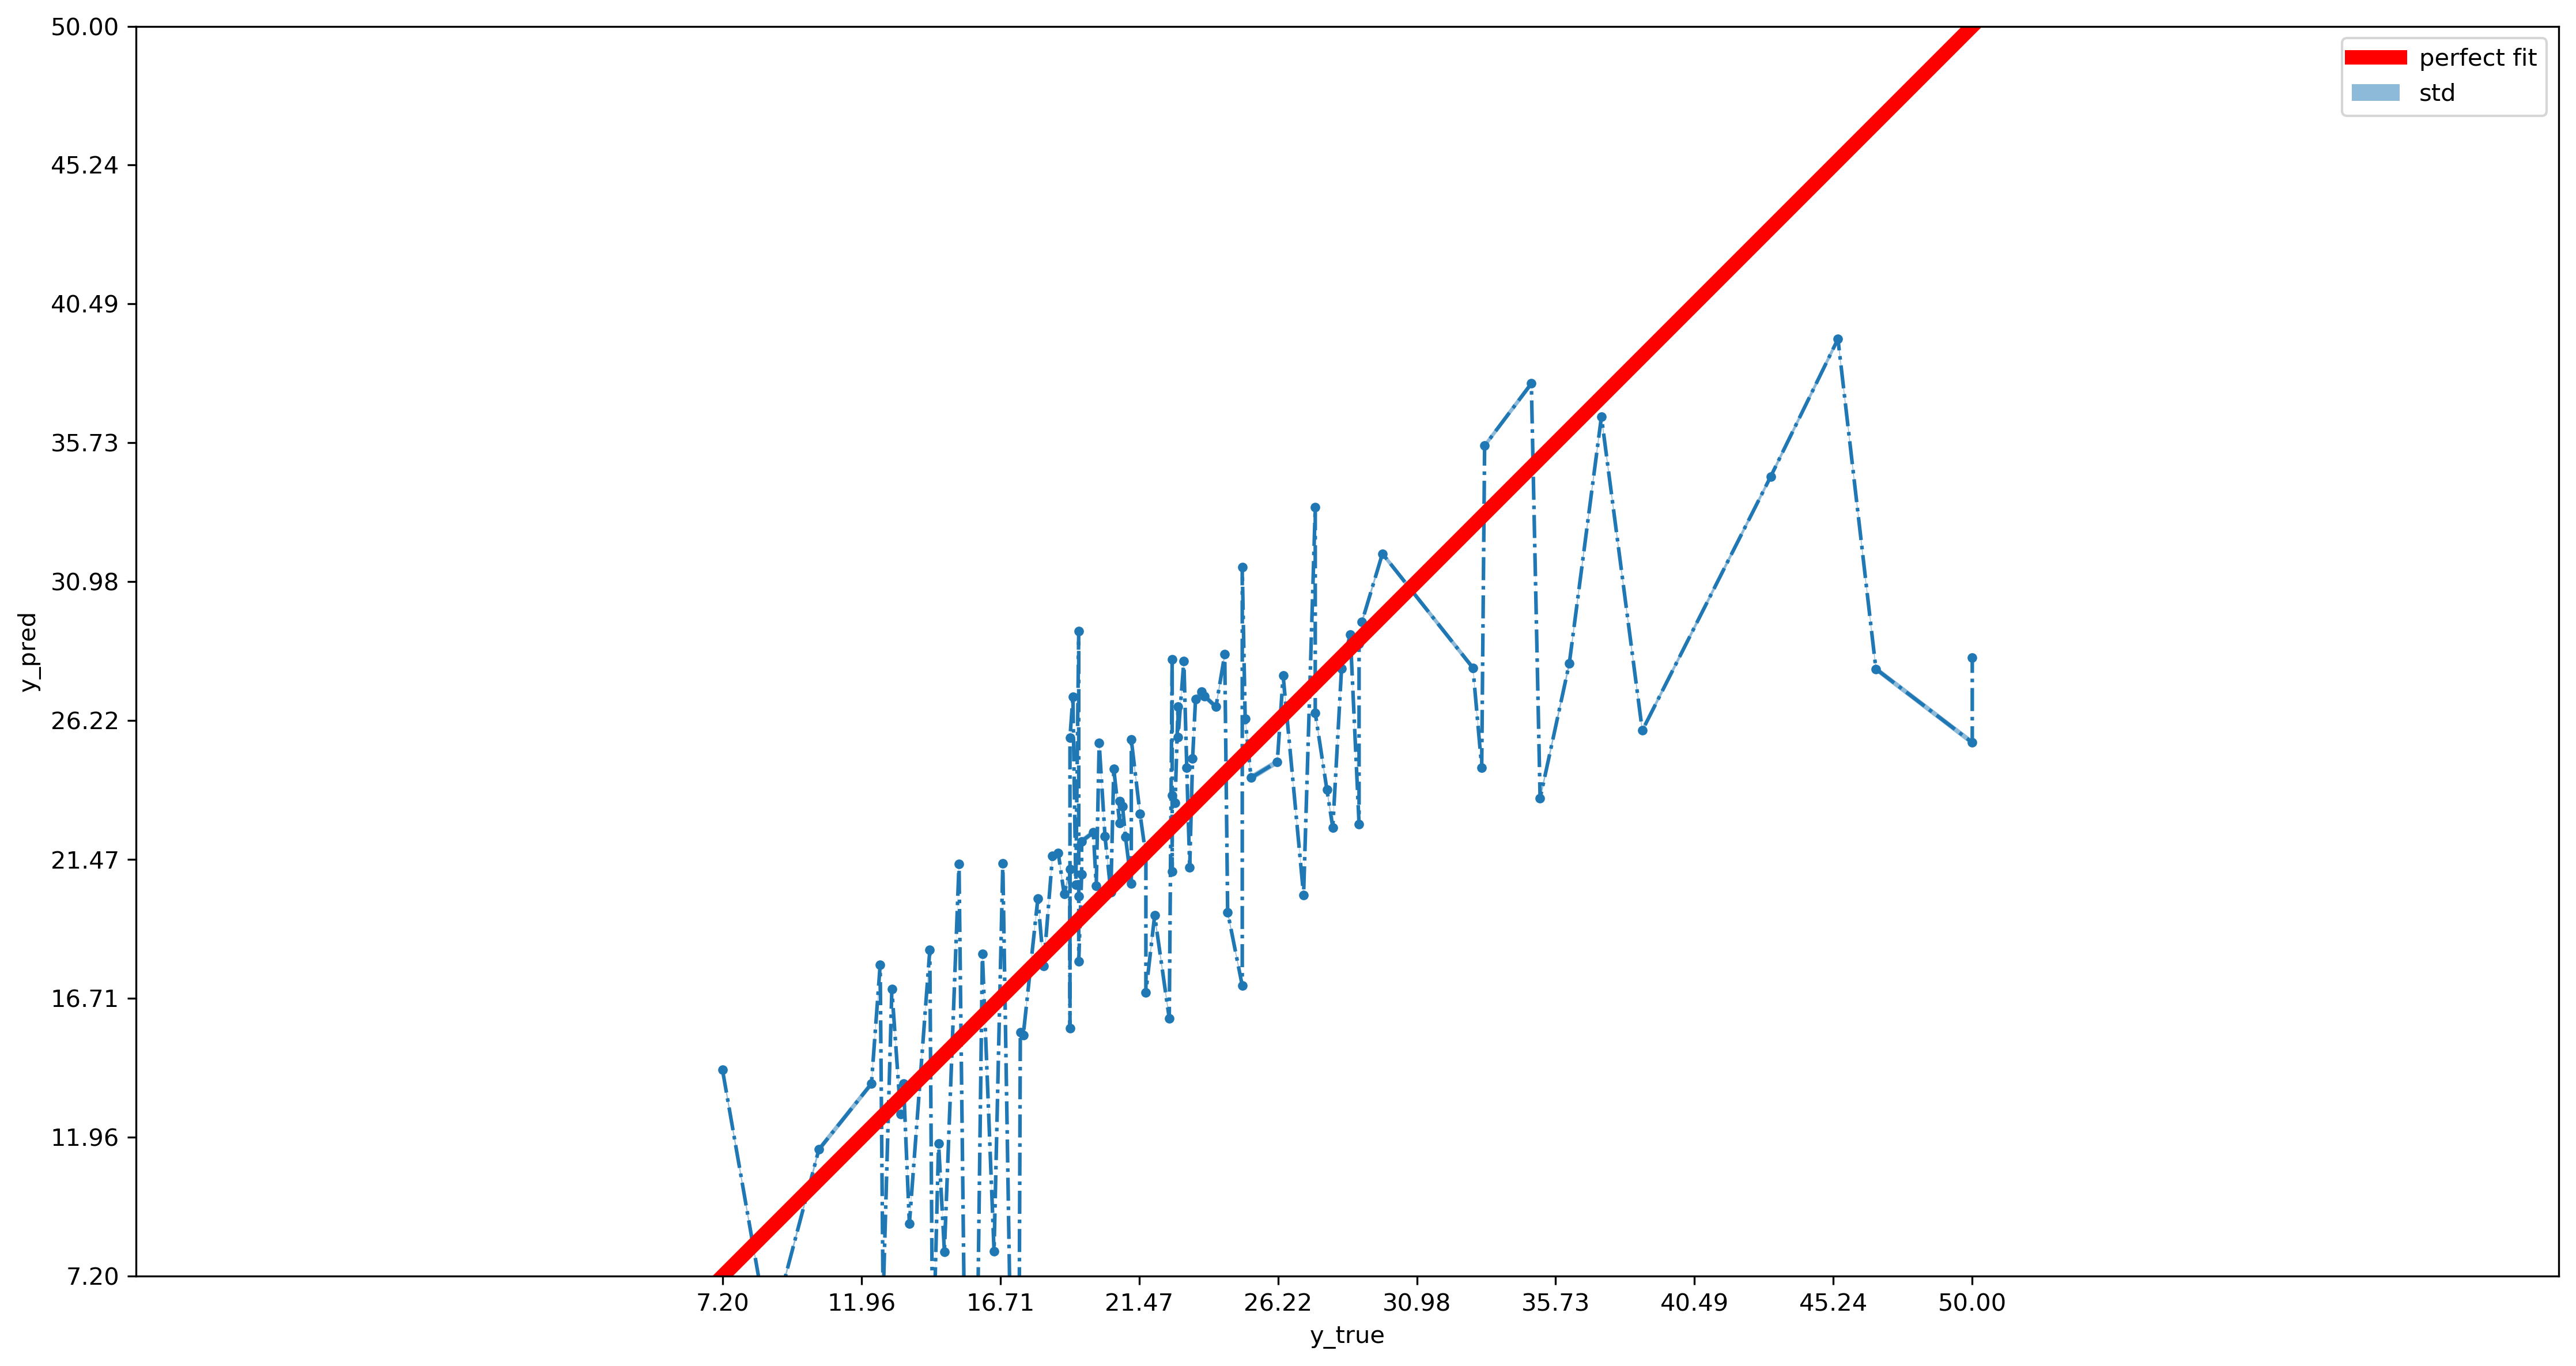

In [38]:
gamma = args.gamma * 100
hmc_transition.gamma = torch.tensor(np.log(gamma), device=device)

n_weights = 1000
model_weights = []


while len(model_weights) < n_weights:
    q_new, _, a = hmc_transition.make_transition(q_old=q_new[None], p_old=None, target_distr=model_new, x=X_train)
    if bool(a.cpu().numpy()):
        model_weights.append(q_new[0].detach())
    q_new = q_new[0]
    gamma *= 0.99
    hmc_transition.gamma = torch.tensor(np.log(gamma), device=device)

with torch.no_grad():
    pred_matrix = torch.empty((n_weights, dataset.x_val.shape[0]), device=device, dtype=torch.float32)
    for i, weights in enumerate(model_weights):
        predictions = torch.tensor([], device=device)
        model_current = copy.deepcopy(load_parameters(model_new, weights, params_shapes))
        for val_batch, val_label in dataset.next_val_batch():
            preds = model_current(val_batch)
            predictions = torch.cat([predictions, preds], dim=0)
        pred_matrix[i, :] = predictions.squeeze()
    true_ans = dataset.y_val
    true_ans = true_ans.squeeze()
    idx = np.argsort(true_ans)
    true_ans = true_ans[idx] #.cpu().numpy()

    pred_ans = pred_matrix.mean(dim=0)[idx].cpu().numpy()
    pred_std = pred_matrix.std(dim=0)[idx].cpu().numpy()
    
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(true_ans, pred_ans, '-..')
plt.fill_between(x=true_ans, y1=pred_ans+2*pred_std, y2=pred_ans-2*pred_std, alpha=0.5, label='std', )
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.axis('equal')
plt.xlim(true_ans.min(), true_ans.max())
plt.ylim(true_ans.min(), true_ans.max())
plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
plt.legend()
plt.tight_layout()
plt.show();